# Kryssvalidering

Vi vil brukte et datasett som inneholder informasjon om 4000 epler og hvor hvert eple er karakterisert som enten bra eller dårlig. Vi vil lage en modell basert på beslutningstrær som kan klassifisere et eple som bra eller dårlig basert på 7 forskjellige parametere. Hovedfokuset i denne notebooken vil derimot være mer på hvordan vi kan bruke de tilgjengelig dataene til å validere modellen og unngå overtrening.

Først leser vi inn datasettet, fjerner ugyldige verdier, gjør om *god* og *dårlig* til 0 og 1 og plukker ut variablene/predikatorene samt target (god eller dårlig) i egne numpy-arrays. Dette bør være kjent stoff fra tidligere så vil ikke kommentere så mye på det som blir gjort. 

In [34]:
import matplotlib.pyplot as plt
#%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.stats import expon
import math
from sklearn import tree
from sklearn.metrics import accuracy_score, \
                            precision_score, recall_score, f1_score, mean_squared_error, \
                            mean_absolute_error, ConfusionMatrixDisplay, confusion_matrix
from IPython.display import Image
from IPython.core.display import HTML 

In [35]:
df = pd.read_csv("./apple_quality.csv")

In [36]:
df.head()

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good

In [37]:
df = df.dropna()

In [38]:
df

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0        0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1        1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2        2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3        3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4        4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   
...      ...       ...       ...        ...          ...        ...       ...   
3995  3995.0  0.059386 -1.067408  -3.714549     0.473052   1.697986  2.244055   
3996  3996.0 -0.293118  1.949253  -0.204020    -0.640196   0.024523 -1.087900   
3997  3997.0 -2.634515 -2.138247  -2.440461     0.657223   2.199709  4.763859   
3998  3998.0 -4.008004 -1.779337   2.366397    -0.200329   2.161435  0.214488   
3999  3999.0  0.278540 -1.715505   0.121217    -1.154075   1.266677 -0.776571   

           Acidity Quality  
0     -0.491590483    good  
1     -0.722809367    good  
2      2.621636473     bad  
3      0.790723217    good  
4      0.501984036    good  
...            ...     ...  
3995   0.137784369     bad  
3996   1.854235285    good  
3997  -1.334611391     bad  
3998  -2.229719806    good  
3999   1.599796456    good  

[4000 rows x 9 columns]

In [39]:
df = df.drop("A_id",axis = 1)

In [40]:
df['quality_num'] = df['Quality'].apply(lambda x: 1.0 if x == "good" else 0.0)

In [41]:
predictors = list(df.columns)
predictors.remove('Quality')
predictors.remove('quality_num')

In [42]:
X = df[predictors].values
Y = df.quality_num.to_numpy()

Først skal vi se på tilfellet hvor vi delere dataene inn i et treningssett og et testsett. Vi bruker allerede eksisterende funskjon i sklearn for dette. Den returnerer X- og Y-vektorer med $80\%$ av dataene for trening og $20\%$ til testing.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Sjekk dimensjonen til treningssettet og testsettet

In [44]:
X_train.shape

(3200, 7)

In [45]:
X_test.shape

(800, 7)

## Trenings- og testsett

Vi lager en modell hvor vi lar dybden til treet vårt være forskjellig (alle verider mellom 1 og 21) siden dette er en parameter som, om vi lar den bli veldig stor, fort fører til overtrening. For å validere metoden bruker vi *accuracy*, som for en klassifiseringsmodell er definert ved

$$\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$$

hvor

$$ 1(\hat{y}_i = y_i) = \begin{cases}
1 & \text{hvis}\, \hat{y}_i = y_i, \\
0 & \text{hvis}\, \hat{y}_i \neq y_i.
\end{cases} $$

In [18]:
# Definerer numpy-arrays til å lagre informasjon om hvert enkelt tre (med ulik dybde)
treedepth = np.zeros((20,))


mean_scores_test = np.zeros((20,))
mean_scores_train = np.zeros((20,))

i = 0
for depth in range(1,21):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train,y_train)
    
    # Bruk modellen på test-data og trenings-data
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    # Hent score (basert på trening og test) etter formelen over 
    # for denne modellen og lagre til senere for plotting
    mean_scores_train[i] = clf.score(X_train, y_train)
    mean_scores_test[i] = clf.score(X_test, y_test)
    
    # For å definere x-aksen
    treedepth[i] = (depth)
    i += 1

Så kan vi plotte score som en funksjon av tredybde for de to tilfellene hvor vi 

1. har validert modellen på treningssettet 
2. har validert modellen på testsettet.

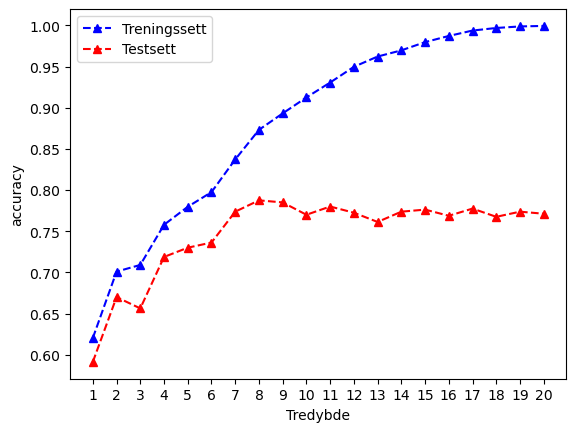

In [19]:
fig, ax = plt.subplots()

plt.plot(treedepth,mean_scores_train,color='blue', marker='^', linestyle='dashed',label='Treningssett')
plt.plot(treedepth,mean_scores_test,color='red', marker='^', linestyle='dashed',label='Testsett')


ax.set_title('')
ax.set_xlabel('Tredybde')
ax.set_ylabel('accuracy')
ax.set_xticks(treedepth) 
plt.legend()

Her ser vi klare tegn til overtrenining siden accuracy for modellen øker og øker når vi bruker treningssettet, mens accuracy ser ut til å flate ut på en tredybde på rundt 9 når vi tester den på testsettet (dvs. at modellen egentlig ikke blir noe bedre på å klassifisere data den ikke har sett etter en dybde på ca. 9). Derimot blir accuarcy nesten 1 dersom vi lar treet vokse helt til en dybde på 21. Det at disse to kurvene er såpass forskjellig er et klart tegn på overtrening og at modellen overoptimaliserer for tilfeldige fluktuasjoner i treningssettet som ikke nødvendigvis er der i testsettet. Altså er modellen vår (med dybde > 9) dårlig til å generalisere og unødvendig komplisert.

En bedre måte å dele opp datasettet vårt i trening og validering er å bruke såkalt kryssvalidering. La oss først se på k-fold kryssvalidering hvor datasettet deles opp på følgende måte:

In [46]:
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png")

Her har vi valgt en k-fold kryssvalidering med 5 splits. Vi holder forstatt en del av dataene utenfor, og som brukes som testsett og ikke på noe punkt inngår i treningen av modellen. De resterende dataene brukes i kryssvalideringen hvor vi deler dataene opp i 5 blokker med like mange datapunkter. Vi tilpasser så modellen vår ved å bruke første "fold" til validering og de resterende til trening. Fold-1 brukes altså til å validere modellen oppnådd ved å trene på de fire andre "foldene", og basert på validerings-folden kan vi finne MSE, accuracy og andre parametere. Vi gjentar så prosessen (*Split2*) hvor vi endrer hvilken fold vi bruker til validering. Når vi har gjort dette for alle 5 splittene sitter vi altså igjen med 5 målinger på modellen vår, trent på 5 ulike versjoner av treningssettet. 

Alt dette er enkelt tilgjengelig via- følgende funksjon:

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
# Numpy-arrays for a lagre resultatene for hver tredybde
mean_scores = np.zeros((20,))
std_scores = np.zeros((20,))

i = 0
# Loop over de ulike tredybpdene 
for depth in range(1,21):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    # Denne gjør selve kryssvalideringen og returnerer 
    # score/accuracy bergenet på de ulike valdierings-delene/foldene 
    # av datasettet (i dette tilfeller altså 5 verdier)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    # Vi finner gjennomsnitt og standardavvik til de 5 målingene
    mean_scores[i] = (scores.mean())
    std_scores[i] = (scores.std())
    
    treedepth[i] = (depth)
    i += 1

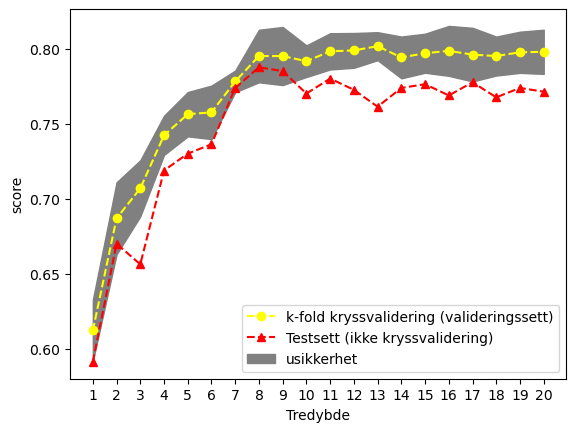

In [49]:
fig, ax = plt.subplots()
plt.plot(treedepth,mean_scores,color='yellow', marker='o', linestyle='dashed',label='k-fold kryssvalidering (valideringssett)')
plt.plot(treedepth,mean_scores_test,color='red', marker='^', linestyle='dashed',label='Testsett (ikke kryssvalidering)')
plt.fill_between(treedepth, mean_scores-std_scores, mean_scores+std_scores,color='gray',label='usikkerhet')
ax.set_xticks(treedepth);
ax.set_title('')
ax.set_xlabel('Tredybde')
ax.set_ylabel('score')
plt.legend()
#plt.ylim(-0.1, 1.1)

Her ser vi liknende resultat som vi fikk for modellen vi testet på testsettet fra i stad (røde punkter).

Vi kan også implementere vår egen kryssvalidering ved å bruke såkalte [kryssvalideringsiteratorer](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) som KFold og LeaveOneOut. De returnerer sett med indekser som definerer trenings- og testsettet for en gitt kryssvalideringsmetode. F.eks. for en k-fold kryssvalidering med 5 splits ser det slik ut: 

In [51]:
from sklearn.model_selection import KFold, LeaveOneOut

# Definer kryssvalideringsiteratoren
kf = KFold(n_splits=5)
#kf = LeaveOneOut()

mse_kf_test = np.zeros((20,kf.get_n_splits(X)))
mse_kf_train = np.zeros((20,kf.get_n_splits(X)))

scores_kf_train = np.zeros((20,kf.get_n_splits(X)))
scores_kf_test = np.zeros((20,kf.get_n_splits(X)))

j = 0
# Loop over alle "split"'ene 
for train, test in kf.split(X):
    print("Doing split %i/%i"%(j,kf.get_n_splits(X)))
    
    # Hent ut trening og testdatasettet fra indeksene 
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X[train], X[test], Y[train], Y[test]
    i = 0
    # Loop over tredybder
    for depth in range(1,21):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(X_train_kf,y_train_kf)
        
        # Bruker den trente på modellen til å predikere 
        # både på testsettet ...
        y_pred_test_kf = clf.predict(X_test_kf)
        # ... og på treningssettet
        y_pred_train_kf = clf.predict(X_train_kf)
    
        #Regner ut MSE
        mse_kf_test[i][j] = mean_squared_error(y_test_kf,y_pred_test_kf)   
        mse_kf_train[i][j] = mean_squared_error(y_train_kf,y_pred_train_kf)   
        
        # ... og score
        scores_kf_train[i][j] = clf.score(X_train_kf, y_train_kf)
        scores_kf_test[i][j] = clf.score(X_test_kf, y_test_kf)
        
        i += 1
        
    j += 1

Doing split 0/5
Doing split 1/5
Doing split 2/5
Doing split 3/5
Doing split 4/5


Prøv gjerne å kjøre en LeaveOneOut, men det tar litt tid. Uansett kan vi regne ut gjennomsnitt og standardavvik for både MSE og score fra alle splitsene:

In [52]:
mse_avg_kf_test = np.zeros((20,))
mse_avg_kf_train = np.zeros((20,))

mse_err_kf_test = np.zeros((20,))
mse_err_kf_train = np.zeros((20,))

score_avg_kf_test = np.zeros((20,))
score_avg_kf_train = np.zeros((20,))

score_err_kf_test = np.zeros((20,))
score_err_kf_train = np.zeros((20,))


std_scores = np.zeros((20,))
for i in range(mse_kf_test.shape[0]):
    mse_avg_kf_test[i] = mse_kf_test[i].mean()
    mse_avg_kf_train[i] = mse_kf_train[i].mean()
    
    mse_err_kf_test[i] = mse_kf_test[i].std()
    mse_err_kf_train[i] = mse_kf_train[i].std()
    
    score_avg_kf_test[i] = scores_kf_test[i].mean()
    score_avg_kf_train[i] = scores_kf_train[i].mean()
    
    score_err_kf_test[i] = scores_kf_test[i].std()
    score_err_kf_train[i] = scores_kf_train[i].std()

... og plotte de

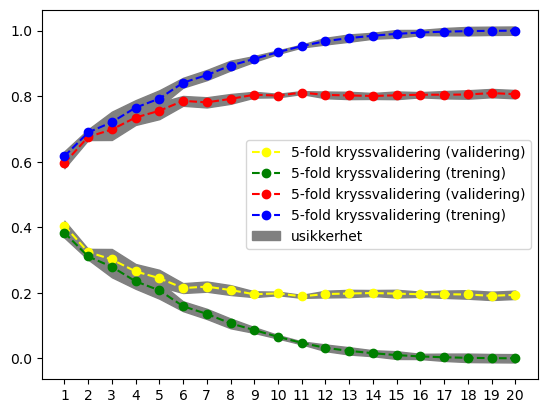

In [53]:
fig, ax = plt.subplots()
plt.plot(treedepth,mse_avg_kf_test,color='yellow', marker='o', linestyle='dashed',label='5-fold kryssvalidering (validering)')

plt.plot(treedepth,mse_avg_kf_train,color='green', marker='o', linestyle='dashed',label='5-fold kryssvalidering (trening)')

plt.plot(treedepth,score_avg_kf_test,color='red', marker='o', linestyle='dashed',label='5-fold kryssvalidering (validering)')
plt.plot(treedepth,score_avg_kf_train,color='blue', marker='o', linestyle='dashed',label='5-fold kryssvalidering (trening)')

plt.fill_between(treedepth, mse_avg_kf_test-mse_err_kf_test, mse_avg_kf_test+mse_err_kf_test,color='gray')
plt.fill_between(treedepth, mse_avg_kf_train-mse_err_kf_test, mse_avg_kf_train+mse_err_kf_test,color='gray')
plt.fill_between(treedepth, score_avg_kf_train-mse_err_kf_test, score_avg_kf_train+mse_err_kf_test,color='gray')
plt.fill_between(treedepth, score_avg_kf_test-mse_err_kf_test, score_avg_kf_test+mse_err_kf_test,label='usikkerhet',color='gray')


ax.set_xticks(treedepth);
plt.legend()

Igjen ser vi det samme som vi har sett tidligere. Etter rundt en dybde på 9 ser det ut til at både score og MSE flater mer eller mindre ut når vi tester modellen på testsettet. 

La oss videre undersøke variansen og hypotesen om at jo flere splits vi kjører i kryssvalideringen jo mer korrelerte blir de ulike treningssettene som vi bruker til å trene modellen i hver split og dermed øker også variansen til modellen

In [54]:
from sklearn.model_selection import KFold, LeaveOneOut

# Vi definerer et sett med uike splits for å sjekke variansen
splits = [2,5,8,10,20,50,80,100,200]

mse_avg_kf_test = np.zeros((len(splits),))
mse_avg_kf_train = np.zeros((len(splits),))

mse_err_kf_test = np.zeros((len(splits),))
mse_err_kf_train = np.zeros((len(splits),))

score_avg_kf_test = np.zeros((len(splits),))
score_avg_kf_train = np.zeros((len(splits),))

score_err_kf_test = np.zeros((len(splits),))
score_err_kf_train = np.zeros((len(splits),))

i = 0
# Looper over splits
for split in splits:

    # Definer en iterator
    kf = KFold(n_splits=split)
    
    mse_kf_test = np.zeros((kf.get_n_splits(X),))
    mse_kf_train = np.zeros((kf.get_n_splits(X),))

    scores_kf_train = np.zeros((kf.get_n_splits(X),))
    scores_kf_test = np.zeros((kf.get_n_splits(X),))

    j = 0
    for train, test in kf.split(X):
        # For hver split trekk ut test og treningssett
        X_train_kf, X_test_kf, y_train_kf, y_test_kf = X[train], X[test], Y[train], Y[test]

        clf = tree.DecisionTreeClassifier(max_depth=6)
        clf = clf.fit(X_train_kf,y_train_kf)

        y_pred_test_kf = clf.predict(X_test_kf)
        y_pred_train_kf = clf.predict(X_train_kf)

        mse_kf_test[j] = mean_squared_error(y_test_kf,y_pred_test_kf)   
        mse_kf_train[j] = mean_squared_error(y_train_kf,y_pred_train_kf)   

        scores_kf_train[j] = clf.score(X_train_kf, y_train_kf)
        scores_kf_test[j] = clf.score(X_test_kf, y_test_kf)


        j += 1
    mse_avg_kf_test[i] = mse_kf_test.mean()
    mse_avg_kf_train[i] = mse_kf_train.mean()

    mse_err_kf_test[i] = mse_kf_test.var()
    mse_err_kf_train[i] = mse_kf_train.var()

    score_avg_kf_test[i] = scores_kf_test.mean()
    score_avg_kf_train[i] = scores_kf_train.mean()

    score_err_kf_test[i] = scores_kf_test.var()
    score_err_kf_train[i] = scores_kf_train.var()
    i += 1


Plot så variansen som en funksjon av antall splits

Text(0, 0.5, 'varians')

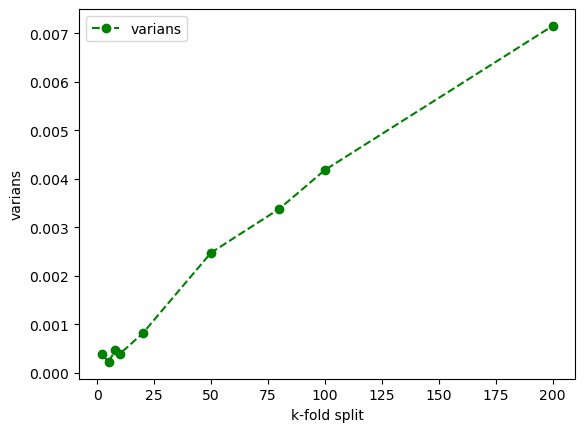

In [55]:
fig, ax = plt.subplots()
plt.plot(splits,mse_err_kf_test,color='green', marker='o', linestyle='dashed',label='varians')
plt.legend()
ax.set_title('')
ax.set_xlabel('k-fold split')
ax.set_ylabel('varians')

Som forventet ser vi at variansen øker når antall splits øker fordi korrelasjonen mellom hvert enkelt treningssett øker (de blir likere og likere). 

## Bruk av kryssvalidering i hyperparameteroptimering

En vktig del av maskinlæring er optimaliseringen av hyperparameterne til modellen (dvs. parameterne som definerer arkitekturen til modellen - sånn som f.eks. tredybden). F.eks. kan man sette en rekke parametere for beslutningstrær (se [dokumentasjonen](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier])). Ved å bruke kryssvalidering kan man da optimalisere parameterne og finne den modellen som gir best score på valideringssettet.

In [30]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
parameters = {'criterion':['gini','entropy'],
              'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

# create an instance of the grid search object
g1 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
g1.fit(X_train,y_train)

# show best parameter configuration found for classifier
cls_params1 = g1.best_params_
cls_params1

CPU times: user 17.3 s, sys: 3.7 s, total: 21 s
Wall time: 24.8 s


{'criterion': 'gini',
 'max_depth': 9,
 'max_leaf_nodes': 21,
 'min_samples_split': 2}

In [31]:
# compute performance on training set
model = g1.best_estimator_
y_pred = model.predict(X_train)
print('accuracy score: %.2f' % accuracy_score(y_train,y_pred))
print('precision score: %.2f' % precision_score(y_train,y_pred))
print('recall score: %.2f' % recall_score(y_train,y_pred))
print('f1 score: %.2f' % f1_score(y_train,y_pred))

accuracy score: 0.82
precision score: 0.78
recall score: 0.88
f1 score: 0.83


In [32]:
# compute performance on test set
model = g1.best_estimator_
y_pred = model.predict(X_test)
print('accuracy score: %.2f' % accuracy_score(y_test,y_pred))
print('precision score: %.2f' % precision_score(y_test,y_pred))
print('recall score: %.2f' % recall_score(y_test,y_pred))
print('f1 score: %.2f' % f1_score(y_test,y_pred))

accuracy score: 0.76
precision score: 0.71
recall score: 0.85
f1 score: 0.77


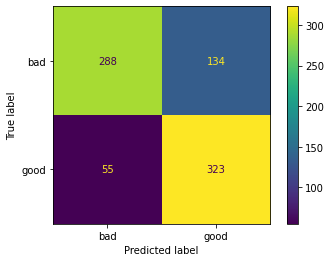

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),display_labels=["bad","good"])
disp.plot()

Se forøvrig [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) og [wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) for mer informasjon på hvordan de ulike scorene er regnet ut. 

In [106]:
288+134+55+323

800

Precision Score:

In [116]:
(323)/(323+134)

0.7067833698030634

Recall Score:

In [57]:
(323)/(323+55)

0.8544973544973545